<h1><center> Uber & Lyft Price Prediction with Neural Network </center></h1>

In [288]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras

pd. set_option("display.max_columns", None)
%matplotlib inline

In [289]:
df_cab = pd.read_csv('cab_rides.csv')
df_cab.head(3)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft


In [290]:
df_w = pd.read_csv('weather.csv')
df_w.head(3)

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07


## Data Cleaning

In [291]:
df_cab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [292]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


In [293]:
df_cab.isna().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [294]:
df_w.isna().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

In [295]:
df_cab = df_cab.dropna(axis=0).reset_index(drop=True)

In [296]:
df_w = df_w.fillna(0)


#### Average Weather 

In [297]:
df_w_avg = df_w.groupby('location').mean().reset_index(drop=False).drop('time_stamp', axis=1)
df_w_avg

,location,temp,clouds,pressure,rain,humidity,wind
0,Back Bay,39.082122,0.678432,1008.447820,0.007925,0.764073,6.778528
1,Beacon Hill,39.047285,0.677801,1008.448356,0.008297,0.765048,6.810325
2,Boston University,39.047744,0.679235,1008.459254,0.007738,0.763786,6.692180
3,Fenway,38.964379,0.679866,1008.453289,0.007343,0.767266,6.711721
4,Financial District,39.410822,0.676730,1008.435793,0.008563,0.754837,6.860019
5,Haymarket Square,39.067897,0.676711,1008.445239,0.008660,0.764837,6.843193
6,North End,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117
7,North Station,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444168,0.007358,0.767648,6.749426
9,South Station,39.394092,0.677495,1008.438031,0.008310,0.755468,6.848948


In [298]:
source_weather_df = df_w_avg.rename(
    columns={
        'location': 'source',
        'temp': 'source_temp',
        'clouds': 'source_clouds',
        'pressure': 'source_pressure',
        'rain': 'source_rain',
        'humidity': 'source_humidity',
        'wind': 'source_wind'
    }
)

source_weather_df

,source,source_temp,source_clouds,source_pressure,source_rain,source_humidity,source_wind
0,Back Bay,39.082122,0.678432,1008.447820,0.007925,0.764073,6.778528
1,Beacon Hill,39.047285,0.677801,1008.448356,0.008297,0.765048,6.810325
2,Boston University,39.047744,0.679235,1008.459254,0.007738,0.763786,6.692180
3,Fenway,38.964379,0.679866,1008.453289,0.007343,0.767266,6.711721
4,Financial District,39.410822,0.676730,1008.435793,0.008563,0.754837,6.860019
5,Haymarket Square,39.067897,0.676711,1008.445239,0.008660,0.764837,6.843193
6,North End,39.090841,0.676730,1008.441912,0.008644,0.764054,6.853117
7,North Station,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444168,0.007358,0.767648,6.749426
9,South Station,39.394092,0.677495,1008.438031,0.008310,0.755468,6.848948


In [299]:
destination_weather_df = df_w_avg.rename(
    columns={
        'location': 'destination',
        'temp': 'destination_temp',
        'clouds': 'destination_clouds',
        'pressure': 'destination_pressure',
        'rain': 'destinatione_rain',
        'humidity': 'destination_humidity',
        'wind': 'destinatione_wind'
    }
)

#### Merging data 

In [300]:
data = df_cab\
.merge(source_weather_df, on='source')\
.merge(destination_weather_df, on='destination')

In [301]:
data.head(3)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,source_temp,source_clouds,source_pressure,source_rain,source_humidity,source_wind,destination_temp,destination_clouds,destination_pressure,destinatione_rain,destination_humidity,destinatione_wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,39.067897,0.676711,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,39.067897,0.676711,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,39.067897,0.676711,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755


## Exploratory Data Analysis

### What drives the demand?

In [302]:
# Impute the unix epoch time to standard date time format
data['time_stamp'] = pd.to_datetime(data['time_stamp'], unit='ms')
data['date'] = data['time_stamp'].dt.date  # extract date
data['hour'] = data['time_stamp'].dt.hour  # extract hour
data['day'] =  data['time_stamp'].dt.strftime('%A')

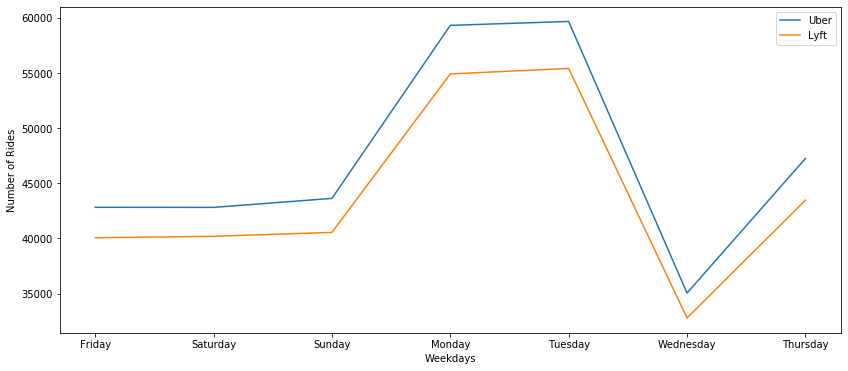

In [303]:
# The distribution of rides in weekdays
uber_day_count = data[data['cab_type'] == 'Uber']['day'].value_counts()
uber_day_count = uber_day_count.reindex(index = ['Friday','Saturday','Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'])

lyft_day_count = data[data['cab_type'] == 'Lyft']['day'].value_counts()
lyft_day_count = lyft_day_count.reindex(index = ['Friday','Saturday','Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'])

fig , ax = plt.subplots(figsize = (14,6))
ax.plot(uber_day_count.index, uber_day_count, label = 'Uber')
ax.plot(lyft_day_count.index, lyft_day_count, label = 'Lyft')
ax.set(ylabel = 'Number of Rides', xlabel = 'Weekdays')
ax.legend()

[Text(0, 0.5, 'Number of Rides'), Text(0.5, 0, 'Hours')]

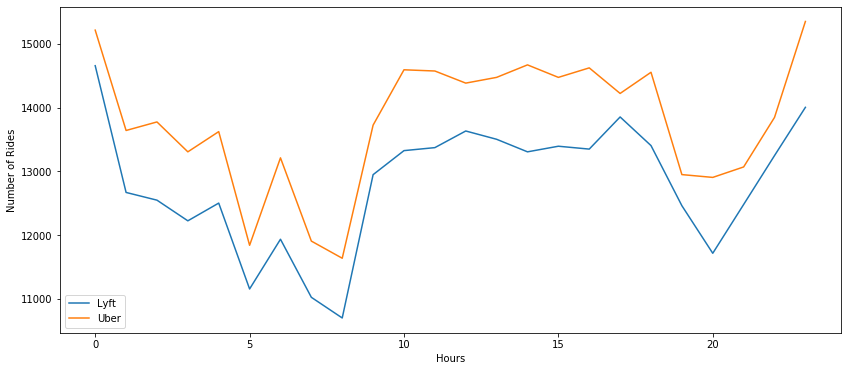

In [304]:
# The ride distribution in one day 
fig , ax = plt.subplots(figsize= (14,6))
ax.plot(data[data['cab_type'] == 'Lyft'].groupby('hour').hour.count().index, data[data['cab_type'] == 'Lyft'].groupby('hour').hour.count(), label = 'Lyft')
ax.plot(data[data['cab_type'] == 'Uber'].groupby('hour').hour.count().index, data[data['cab_type'] =='Uber'].groupby('hour').hour.count(), label = 'Uber')
ax.legend()
ax.set(xlabel = 'Hours', ylabel = 'Number of Rides')
# plt.xticks(range(0,24,1))

In [305]:
data = data.drop('id', axis=1)

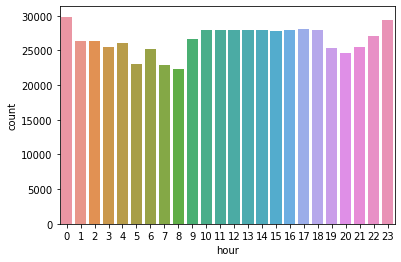

In [306]:
sns.countplot(data['hour'])

The usage is comparitively high between the 10am to 7pm, this is probably due to office hours travel demand

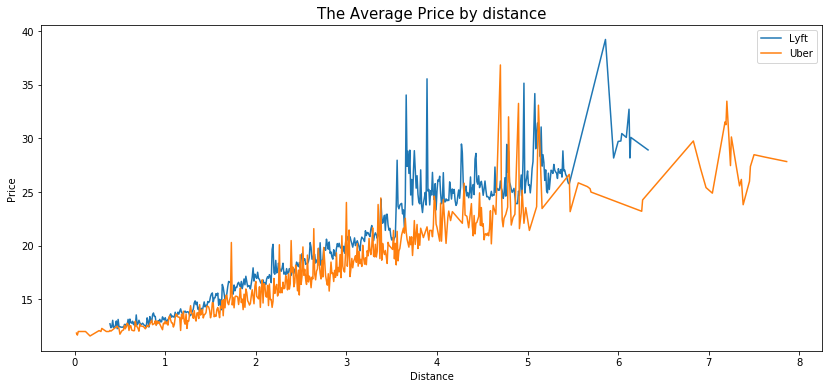

In [307]:
# The average price by distance
fig , ax = plt.subplots(figsize = (14,6))
ax.plot(data[data['cab_type'] == 'Lyft'].groupby('distance').price.mean().index, data[data['cab_type'] == 'Lyft'].groupby('distance')['price'].mean(), label = 'Lyft')
ax.plot(data[data['cab_type'] == 'Uber'].groupby('distance').price.mean().index, data[data['cab_type'] =='Uber'].groupby('distance').price.mean(), label = 'Uber')
ax.set_title('The Average Price by distance', fontsize= 15)
ax.set(xlabel = 'Distance', ylabel = 'Price' )
ax.legend()

### Feature Selection

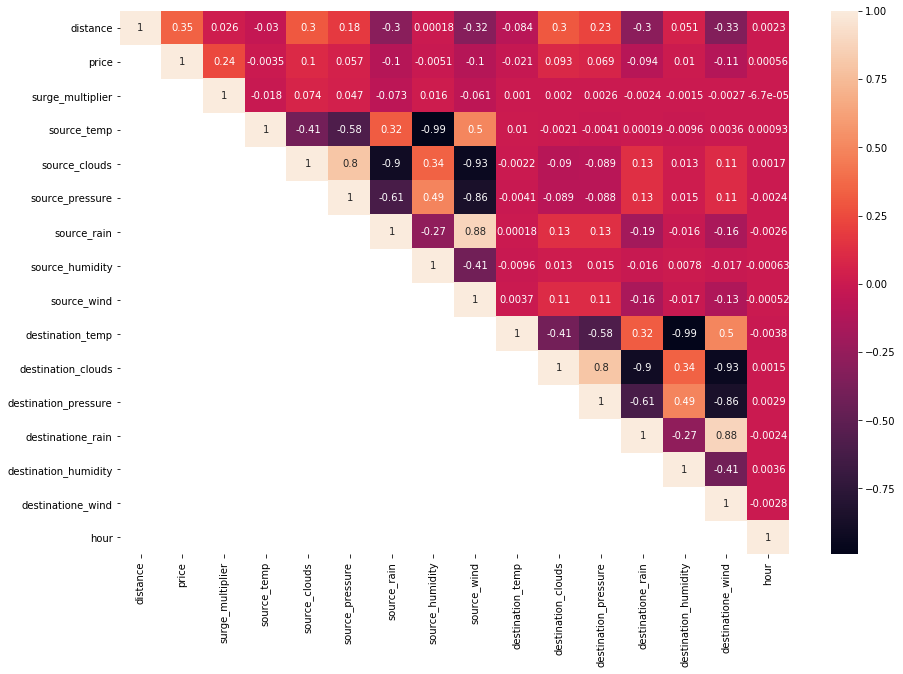

In [308]:
correlation = data.corr()
x = np.tri(correlation.shape[0],k=-1)
plt.figure(figsize=(15,10))
a = sns.heatmap(correlation, annot=True, mask=x)

No significant correlations are observed. So no features are dropped for training.

## Pre-processing

A function is written to one hot encode all the string columns to numeric values

In [309]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix = prefix)
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(column, axis=1)
    return df

In [312]:
def preprocess_inputs(df):
    df = df.copy()
    
    #Drop unwanted columns
    df = df.drop(['time_stamp','date','hour','day'], axis=1)
    
    #Binary-encode cab_type column
    df['cab_type'] = df['cab_type'].replace({'Lyft': 0, 'Uber': 1})
    
    #One-hot encode categorical columns
    for column, prefix in [('destination','dest'), ('source', 'src'),('product_id', 'pid'),('name','nm')]:
        df = onehot_encode(df,column,prefix)
    
    #Split df into X and Y
    y = df['price']
    X = df.drop('price', axis = 1)
    
    #Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True, random_state=1 )
    
    #Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    
#     X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
#     X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [313]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [314]:
X_test.shape

(191393, 63)

## Training - Linear Regression Model

A simple Linear Regression Model is used to train the model

In [37]:
model = LinearRegression()
model.fit(X_train, y_train)

print('Test R^2 score:{:f}'.format(model.score(X_test,y_test)))

Test R^2 score:0.928265


## Neural Network (Using Keras)

In [317]:
model_nn = tf.keras.Sequential([tf.keras.layers.Dense(units=20, input_dim=63),
                                tf.keras.layers.Dense(units=1, activation=tf.nn.relu)])
model_nn.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mae'])
model_nn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 20)                1280      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 21        
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [318]:
model_nn.fit(X_train, y_train, epochs=10)

Epoch 1/10
13956/13956 [==============================] - 8s 551us/step - loss: 7.8911 - mae: 1.9666
Epoch 2/10
13956/13956 [==============================] - 8s 587us/step - loss: 7.1050 - mae: 1.8727
Epoch 3/10
13956/13956 [==============================] - 8s 556us/step - loss: 6.9675 - mae: 1.8594
Epoch 4/10
13956/13956 [==============================] - 8s 555us/step - loss: 6.9505 - mae: 1.8583
Epoch 5/10
13956/13956 [==============================] - 8s 554us/step - loss: 6.9495 - mae: 1.8586
Epoch 6/10
13956/13956 [==============================] - 8s 552us/step - loss: 6.9158 - mae: 1.8565
Epoch 7/10
13956/13956 [==============================] - 8s 559us/step - loss: 6.9175 - mae: 1.8570
Epoch 8/10
13956/13956 [==============================] - 8s 572us/step - loss: 6.9261 - mae: 1.8569
Epoch 9/10
13956/13956 [==============================] - 8s 556us/step - loss: 6.9161 - mae: 1.8563
Epoch 10/10
13956/13956 [==============================] - 8s 562us/step - loss: 6.9284 - m

Note: During model prediction, slicing of the array is done in order to keep the dimensions right

In [319]:
model_nn.predict(X_test[0:1])

array([[28.287676]], dtype=float32)

In [321]:
y_test[0:1]

606015    27.5
Name: price, dtype: float64

In [322]:
model_nn.evaluate(X_test, y_test)

5982/5982 [==============================] - 3s 511us/step - loss: 6.6912 - mae: 1.7944


[6.691244125366211, 1.7944313287734985]